<a href="https://colab.research.google.com/github/Belac44/Fraud-Detection-Deployment/blob/main/Fraud_Detection_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Fraud Dataset/fraud.csv")
df.shape

(6362620, 11)

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
#Observe the number of unique items in each column
for column in df.columns:
  print(f"{column} : ",df[column].nunique())
  

step :  743
type :  5
amount :  5316900
nameOrig :  6353307
oldbalanceOrg :  1845844
newbalanceOrig :  2682586
nameDest :  2722362
oldbalanceDest :  3614697
newbalanceDest :  3555499
isFraud :  2
isFlaggedFraud :  2


In [8]:
#Type seems to have the least numnber of unique items. Only five. Here are the diff transaction types
df["type"].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [9]:
#There seems to be an unbalance between the fraud and non-fraud. This will geartly affect our model if not downsampled
df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [10]:
#This columns look utterly useless so we drop it
df["isFlaggedFraud"].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [11]:
df = df.drop(columns="isFlaggedFraud")

In [12]:
#Observe the fraud transaction to get anything unusual
df[df["isFraud"] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1


In [13]:
#Namedest looks kind of absurd. We would expect most fraud transactions to be channeled to a single Destination
df[df["isFraud"] == 0]["nameDest"].value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M435905844       1
M534128698       1
M2140757139      1
M316120022       1
C855350324       1
Name: nameDest, Length: 2719685, dtype: int64

In [14]:
#Knowing if there are certain locations where most fraud transcations lead to
df[df["isFraud"] == 1]["nameDest"].value_counts()

C1193568854    2
C104038589     2
C200064275     2
C1497532505    2
C1601170327    2
              ..
C317811789     1
C24324787      1
C1053414206    1
C2013070624    1
C873221189     1
Name: nameDest, Length: 8169, dtype: int64

In [15]:
#C1286084959 seems to get 113 non-fraud transactions. Lets see if there is any fraud channels to the same dest
df[df["nameDest"] == "C1286084959"]["isFraud"].value_counts()

0    113
Name: isFraud, dtype: int64

In [16]:
# No fraud transactions to above destination. Lets sees the first 10 transactions too
# Not even one fraudulent transaction to those destinations. I actually did for most of first 100 transaction and
# only 5 of them have a fraudulent transaction. and only one in each case
most_transacted_dest = df[df["isFraud"] == 0]["nameDest"].value_counts().index

for col in most_transacted_dest[:5]:
  print(df[df["nameDest"] == col]["isFraud"].value_counts(),"\n")

0    113
Name: isFraud, dtype: int64 

0    109
Name: isFraud, dtype: int64 

0    105
Name: isFraud, dtype: int64 

0    102
Name: isFraud, dtype: int64 

0    101
Name: isFraud, dtype: int64 



In [17]:
#Knowing if there is acertain step with more fraud transcations than others and its damn clear, 212 has a lot of
# fraud transcations
df[df["isFraud"] == 1]["step"].value_counts()

212    40
523    30
387    28
425    28
249    28
       ..
202     2
589     2
112     2
548     2
662     2
Name: step, Length: 741, dtype: int64

In [18]:
#Step 19 0n the other hand has a lot of non-fraud transcations
df[df["isFraud"] == 0]["step"].value_counts()

19     51341
18     49563
187    49073
235    47481
307    46952
       ...  
454       33
529       27
613       25
675       20
712       11
Name: step, Length: 423, dtype: int64

In [19]:
#lets see the number of fraud transactions with  19 as their step. Only 11
df[df["isFraud"] == 1][df["step"] == 19].shape[0]

11

In [20]:
#lets see the number of non-fraud transactions with  212 as their step. A lot of them indeed
df[df["isFraud"] == 0][df["step"] == 212].shape[0]

34007

In [21]:
#Step looks to be an important column to help flag a transaction as fraudulent or not.

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [22]:
dest = df.copy()

In [23]:
# dest["nameDest"] = df["nameDest"].str.replace("M","")
# dest.head()

In [24]:
sum_C = 0
sum_M = 0

for col in dest["nameDest"]:
  if col[0] == "M":
    sum_M += 1
  elif col[0] == "C":
    sum_C += 1

print(sum_C)
print(sum_M)

4211125
2151495


In [25]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [26]:
#We want all our columns to be numbers so we drop the first letter in each Origin and Destination.
df["nameOrig"] = df["nameOrig"].str.replace("C","")
df["nameDest"] = df["nameDest"].str.replace("M", "")
df["nameDest"] = df["nameDest"].str.replace("C", "")

In [27]:
df["nameOrig"] = pd.to_numeric(df["nameOrig"])
df["nameDest"] = pd.to_numeric(df["nameDest"])

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 485.4+ MB


In [29]:
#The only objcet we now have is type but since it has only five uniwue types, we can label encode it

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["type"] = le.fit_transform(df["type"])
df["type"].value_counts()

1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: type, dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(5)
memory usage: 485.4 MB


In [31]:
X = df.drop(columns="isFraud")
y = df["isFraud"]

In [32]:
#Split our data to train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=17, stratify=y)

print(".....................................................Report.......................................................................")
print("Y train count")
print(y_train.value_counts())
print("\n\nY_test count")
print(y_test.value_counts())

# There is massive imbalance within our data.
# We have to downsample or upsample but lets go with downsampling
from imblearn.over_sampling import SMOTE

nm = SMOTE(sampling_strategy=0.8)
X_train_miss, y_train_miss = nm.fit_resample(X_train, y_train)

print('Before Undersampling, the shape of train_X: {}'.format(X_train.shape))
print('Before Undersampling, the shape of train_y: {} \n'.format(y_train.shape))

print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

.....................................................Report.......................................................................
Y train count
0    3177204
1       4106
Name: isFraud, dtype: int64


Y_test count
0    3177203
1       4107
Name: isFraud, dtype: int64
Before Undersampling, the shape of train_X: (3181310, 9)
Before Undersampling, the shape of train_y: (3181310,) 

After Undersampling, the shape of train_X: (5718967, 9)
After Undersampling, the shape of train_y: (5718967,) 

After Undersampling, counts of label '1': 2541763
After Undersampling, counts of label '0': 3177204


In [33]:
X_test.shape

(3181310, 9)

In [35]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=17)
rfc.fit(X_train_miss, y_train_miss)

y_pred = rfc.predict(X_test)

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

print("\n\nF1 SCore: ",f1_score(y_test,y_pred))



F1 SCore:  0.7414452214452215


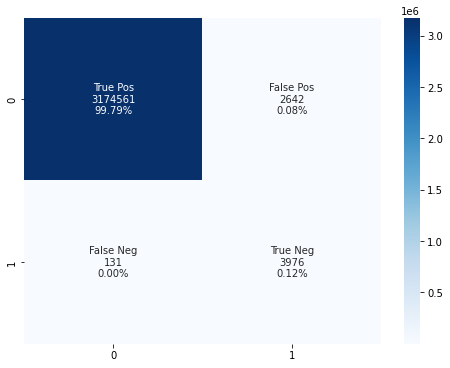

In [36]:
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
test_cnf_matrix = confusion_matrix(y_true=y_test,y_pred=y_pred)
test_counts = ["{0:0.0f}".format(value) for value in test_cnf_matrix.flatten()]
test_percentage = ["{0:.2%}".format(value) for value in test_cnf_matrix .flatten()/np.sum(test_cnf_matrix)]
test_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,test_counts,test_percentage)]
test_labels = np.asarray(test_labels).reshape(2,2)
plt.figure(figsize = (8,6))
sns.heatmap(test_cnf_matrix, annot=test_labels, fmt='', cmap='Blues')

In [37]:
import pickle

pickle.dump(rfc, open('model.pkl', 'wb'))

In [38]:
pickled_model = pickle.load(open('model.pkl', 'rb'))


KeyboardInterrupt: ignored

In [39]:
X_train.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest'],
      dtype='object')

In [40]:
X_test.iloc[0]

step              3.560000e+02
type              3.000000e+00
amount            1.270043e+04
nameOrig          1.943818e+09
oldbalanceOrg     0.000000e+00
newbalanceOrig    0.000000e+00
nameDest          3.453250e+08
oldbalanceDest    0.000000e+00
newbalanceDest    0.000000e+00
Name: 5117095, dtype: float64

In [41]:
data = np.array(X_test.iloc[143])
pickled_model.predict(data.reshape(1,-1))

array([0])

In [ ]:
X_test.head()